In [1]:
# Imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

warnings.filterwarnings("ignore")
warnings.showwarning = False

In [49]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
train = image_dataset_from_directory('animal_data', labels='inferred', label_mode='int', subset='training', 
                                      validation_split=0.1, image_size=[224, 224], interpolation='nearest', 
                                      batch_size=64, shuffle=True, seed=0)
valid = image_dataset_from_directory('animal_data', labels='inferred', label_mode='int', subset='validation', 
                                     validation_split=0.1, image_size=[224, 224], interpolation='nearest', 
                                     batch_size=64, shuffle=True, seed=0)
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

Found 1944 files belonging to 15 classes.
Using 1750 files for training.
Found 1944 files belonging to 15 classes.
Using 194 files for validation.


In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (train.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
valid = (valid.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

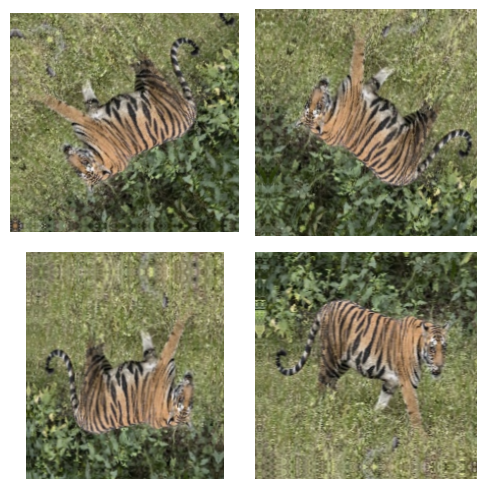

In [51]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    #preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)])

ex = next(iter(train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(5,5))
for i in range(4):
    image = augment(ex, training=True)
    plt.subplot(2, 2, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [5]:
#pretrained model VGG16
pretrained_base = tf.keras.models.load_model('../Pretrained CNNs/cv-course-models/vgg16-pretrained-base', compile=False)

model = keras.Sequential([pretrained_base, layers.Flatten(), layers.Dense(6, activation='relu'),
    layers.Dense(15, activation='sigmoid')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(train, validation_data=valid, epochs = 1)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

Epoch 1/15
28/28 [==============================] - 38s 1s/step - loss: 2.7076 - categorical_accuracy: 0.0789 - val_loss: 2.7139 - val_categorical_accuracy: 0.0567
Epoch 2/15
28/28 [==============================] - 39s 1s/step - loss: 2.7037 - categorical_accuracy: 0.0800 - val_loss: 2.7050 - val_categorical_accuracy: 0.0464
Epoch 3/15
28/28 [==============================] - 39s 1s/step - loss: 2.7028 - categorical_accuracy: 0.0674 - val_loss: 2.7536 - val_categorical_accuracy: 0.0619
Epoch 4/15
28/28 [==============================] - 39s 1s/step - loss: 2.6962 - categorical_accuracy: 0.0749 - val_loss: 2.7014 - val_categorical_accuracy: 0.0515
Epoch 5/15
28/28 [==============================] - 39s 1s/step - loss: 2.6922 - categorical_accuracy: 0.0806 - val_loss: 2.7684 - val_categorical_accuracy: 0.0464
Epoch 6/15
28/28 [==============================] - 39s 1s/step - loss: 2.7354 - categorical_accuracy: 0.0800 - val_loss: 2.7074 - val_categorical_accuracy: 0.0464
Epoch 7/15
28/28

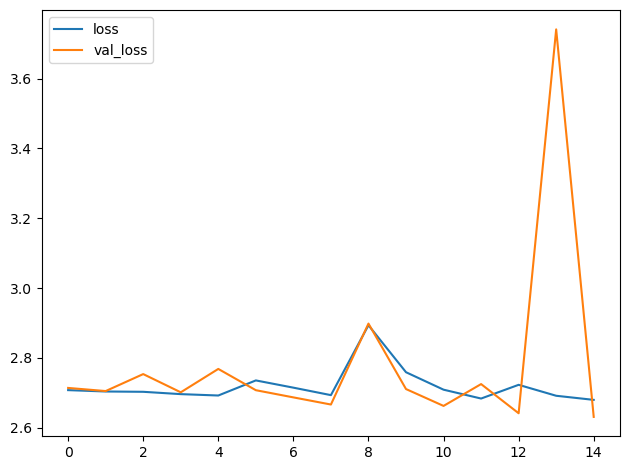

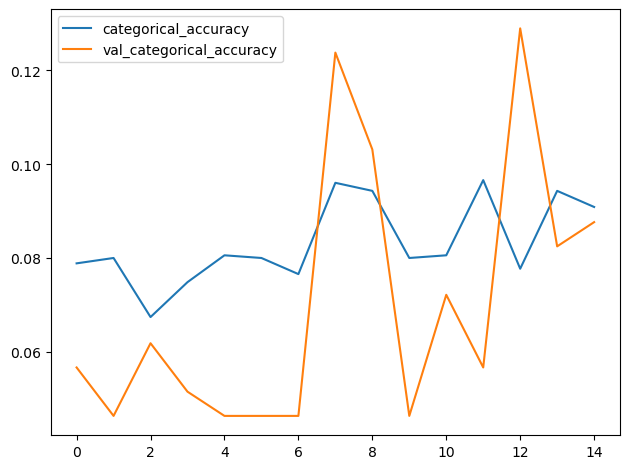

In [11]:
#1st model
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=1),
    preprocessing.RandomFlip(mode = 'horizontal'),
    preprocessing.RandomFlip(mode = 'vertical'),
    preprocessing.RandomRotation(factor = 0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(15, activation='sigmoid')])


optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(train, validation_data=valid, epochs=15)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

Epoch 1/15
28/28 [==============================] - 42s 1s/step - loss: 2.7062 - categorical_accuracy: 0.0754 - val_loss: 2.7025 - val_categorical_accuracy: 0.1031
Epoch 2/15
28/28 [==============================] - 42s 1s/step - loss: 2.6948 - categorical_accuracy: 0.0829 - val_loss: 2.6641 - val_categorical_accuracy: 0.0773
Epoch 3/15
28/28 [==============================] - 41s 1s/step - loss: 2.6724 - categorical_accuracy: 0.0909 - val_loss: 2.6287 - val_categorical_accuracy: 0.0825
Epoch 4/15
28/28 [==============================] - 40s 1s/step - loss: 2.6549 - categorical_accuracy: 0.1000 - val_loss: 2.6303 - val_categorical_accuracy: 0.0825
Epoch 5/15
28/28 [==============================] - 40s 1s/step - loss: 2.5914 - categorical_accuracy: 0.1234 - val_loss: 2.6026 - val_categorical_accuracy: 0.1649
Epoch 6/15
28/28 [==============================] - 40s 1s/step - loss: 2.6543 - categorical_accuracy: 0.1177 - val_loss: 2.5939 - val_categorical_accuracy: 0.1082
Epoch 7/15
28/28

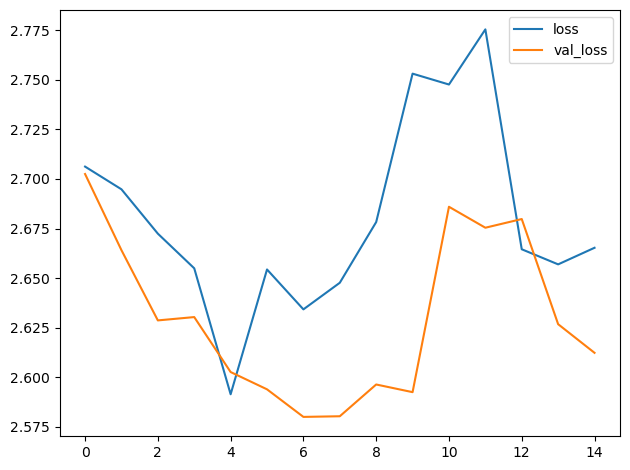

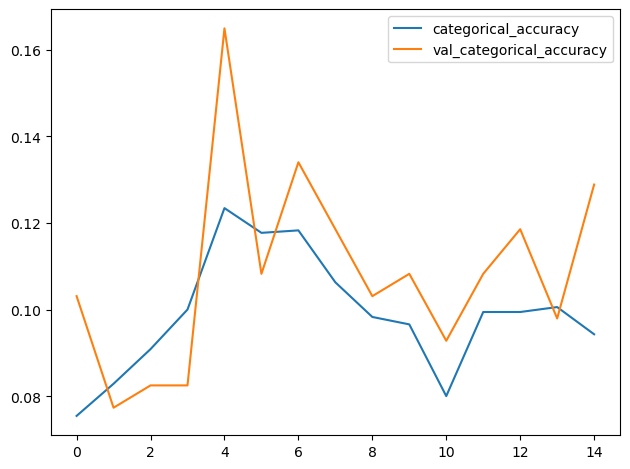

In [16]:
#2nd model
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=1),
    preprocessing.RandomFlip(mode = 'horizontal'),
    preprocessing.RandomFlip(mode = 'vertical'),
    preprocessing.RandomRotation(factor = 0.50),
    preprocessing.RandomRotation(factor=0.20),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(15, activation='sigmoid')])


optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(train, validation_data=valid, epochs=15)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [20]:
#pretrained model VGG16
pretrained_base = tf.keras.models.load_model('../Pretrained CNNs/cv-course-models/vgg16-pretrained-base', compile=False)

model = keras.Sequential([pretrained_base, layers.Flatten(), layers.Dense(128, activation='relu'),
    layers.Dense(15, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train, validation_data=valid, epochs = 30)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Epoch 1/30
28/28 [==============================] - 136s 5s/step - loss: 2.8129 - accuracy: 0.0737 - val_loss: 2.7197 - val_accuracy: 0.0722
Epoch 2/30
28/28 [==============================] - 137s 5s/step - loss: 2.7133 - accuracy: 0.0686 - val_loss: 2.7084 - val_accuracy: 0.0619
Epoch 3/30
13/28 [============>.................] - ETA: 1:13 - loss: 2.7079 - accuracy: 0.0589

KeyboardInterrupt: 

In [22]:
#pretrained model VGG16

from keras.applications.vgg16 import VGG16
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(128,128,3))

pretrained_base = vgg

model = keras.Sequential([pretrained_base, layers.Flatten(), layers.Dense(128, activation='relu'),
    layers.Dense(15, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train, validation_data=valid, epochs = 30)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Epoch 1/30
28/28 [==============================] - 136s 5s/step - loss: 3.2089 - accuracy: 0.0577 - val_loss: 2.7095 - val_accuracy: 0.0825
Epoch 2/30
28/28 [==============================] - 136s 5s/step - loss: 2.7149 - accuracy: 0.0726 - val_loss: 2.7170 - val_accuracy: 0.0464
Epoch 3/30
28/28 [==============================] - 135s 5s/step - loss: 2.7096 - accuracy: 0.0720 - val_loss: 2.7098 - val_accuracy: 0.0619
Epoch 4/30
28/28 [==============================] - 133s 5s/step - loss: 2.6983 - accuracy: 0.0874 - val_loss: 2.6829 - val_accuracy: 0.1134
Epoch 5/30
28/28 [==============================] - 134s 5s/step - loss: 2.6820 - accuracy: 0.0931 - val_loss: 2.7104 - val_accuracy: 0.0773
Epoch 6/30
28/28 [==============================] - 134s 5s/step - loss: 2.6800 - accuracy: 0.0817 - val_loss: 2.6479 - val_accuracy: 0.0979
Epoch 7/30
28/28 [==============================] - 133s 5s/step - loss: 2.7112 - accuracy: 0.0697 - val_loss: 2.7078 - val_accuracy: 0.0722
Epoch 8/30
28

KeyboardInterrupt: 

In [52]:
model = keras.Sequential()
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
vgg.trainable=False
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(15, activation='softmax'))
model.build(input_shape=(None,224,224,3))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history=model.fit(train,validation_data=valid,epochs=10)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_41 (Dense)            (None, 128)               3211392   
                                                                 
 dense_42 (Dense)            (None, 15)                1935      
                                                                 
Total params: 17928015 (68.39 MB)
Trainable params: 3213327 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/10
28/28 [==============================] - 94s 3s/step - loss: 2.9042 - accuracy: 0.2029 - val_loss: 2.0622 - val_accuracy: 0.386